# Version: Direct translation from MatLab

## Functions

In [15]:
import numpy
import matplotlib.pyplot as plt

### Integrator: Runge-Kutta 4th

In [16]:
def runge45_1D(h,t,p,f,flag_pert,pert_params):
    A2 = 0.2;
    A3 = 0.3;
    A4 = 0.6;
    A5 = 1.0;
    A6 = 0.875;
    B21 = 0.2;
    B31 = 3 / 40;
    B32 = 9 / 40;
    B41 = 0.3;
    B42 = -0.9;
    B43 = 1.2;
    B51 = -11 / 54;
    B52 = 2.5;
    B53 = -70 / 27;
    B54 = 35 / 27;
    B61 = 1631 / 55296;
    B62 = 175 / 512;
    B63 = 575 / 13824;
    B64 = 44275 / 110592;
    B65 = 253 / 4096;
    C1 = 37 / 378;
    C3 = 250 / 621;
    C4 = 125 / 594;
    C6 = 512 / 1771;
    DC1 = C1 - 2825 / 27648; 
    DC3 = C3 - 18575 / 48384; 
    DC4 = C4 - 13525 / 55296; 
    DC5 = -277 / 14336;
    DC6 = C6 - 0.25;
    
    ak1 = f(t,p,flag_pert,pert_params);
    p_temp = p + B21 * h * ak1;
        
    ak2 = f(t + A2 * h,p_temp,flag_pert,pert_params);
    p_temp = p + h * (B31 * ak1 + B32 * ak2);
    
    ak3 = f(t + A3 * h,p_temp,flag_pert,pert_params);
    p_temp = p + h * (B41 * ak1 + B42 * ak2 + B43 * ak3);
    
    ak4 = f(t + A4 * h,p_temp,flag_pert,pert_params);
    p_temp = p + h * (B51 * ak1 + B52 * ak2 + B53 * ak3 + B54 * ak4);
    
    ak5 = f(t + A5 * h,p_temp,flag_pert,pert_params);
    p_temp = p + h * (B61 * ak1 + B62 * ak2 + B63 * ak3 + B64 * ak4 + B65 * ak5);
    
    ak6 = f(t + A6 * h,p_temp,flag_pert,pert_params);
    
    p_new = p + h * (C1 * ak1 + C3 * ak3 + C4 * ak4 + C6 * ak6);
    p_err = h * (DC1 * ak1 + DC3 * ak3 + DC4 * ak4 + DC5 * ak5 + DC6 * ak6);
    
    return p_new, p_err

### Vector fields

CHANGES: Redefined `pert` to correct form.

In [17]:
def forcing(t,p,flag_pert,pert_params):
    x = p[:,0];

    pert = numpy.zeros((p.shape[0],1));   
    
    A = pert_params[0];  # Amplitude of perturbation
    freq = pert_params[1];  # Frequency of perturbation
    
    if flag_pert == 1:
        pert = A * numpy.sin(freq*t);
    elif flag_pert == 2:
        pert = A * numpy.sech(t) * numpy.sin(freq*t);
    else:
        pert = pert;

    return pert

In [18]:
def HamCenter_1D(t,p,flag_pert,pert_params):
   
    vel = numpy.zeros((p.shape[0],2));
       
    pert = forcing(t,p,flag_pert,pert_params);
    
    # Hamiltonian Model Parameter
    omega = 1;
    
    x = p[:,0];
    y = p[:,1];
       
    vel[:,0] = omega * y;
    vel[:,1] = - omega * x + pert;

    return vel

In [19]:
def HamSaddle_1D(t,p,flag_pert,pert_params):
   
    vel = numpy.zeros((p.shape[0],2));
    
    pert = forcing(t,p,flag_pert,pert_params);
       
    # Hamiltonian Model Parameter
    lamda = 1;
    
    x = p[:,0];
    y = p[:,1];
    
    vel[:,0] = lamda * y;
    vel[:,1] = lamda * x + pert;
    
    return vel

In [20]:

def HamDuffing_1D(t,p,flag_pert,pert_params):
    
    vel = numpy.zeros((p.shape[0],2));
      
    pert = forcing(t,p,flag_pert,pert_params);
    
    x = p[:,0];
    y = p[:,1];
       
    vel[:,0] = y;
    vel[:,1] = x - x**3 + pert;

    return vel

### LD accumulator

In [21]:
def accum_LDs(LD_val,pts,pts_new,flag_m,p,dt):
    if flag_m: # p-norm LDs
        accum = LD_val + ((abs(pts_new[:,0] - pts[:,0]))**p + (abs(pts_new[:,1] - pts[:,1]))**p) * dt ** (1 - p);
    else:  # arclength LDs
        accum = LD_val + sqrt((pts_new[:,0] - pts_new[:,0])**2 + (pts_new[:,1] - pts[:,1])**2);
    return accum

### LD calculator

In [22]:

def LDs_1D(t0,tau,flag_m,p_val,dt,xi,xf,nx,yi,yf,ny,vf_name,flag_pert,pert_params):
    # @author: V. J. García-Garrido                                                                           
    # Date: 24-04-2020
    
    # %%%%%%%%%%%%%%5%%%%%%%%%%%%%%%%%%%%
    #                                  FUNCTION PARAMETERS                                                 
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # t0                  = Initial Time
    # flag_m          = Flag that determines the type of LD calculated
    #                         0 (arclength) // 1 (p-norm)
    # p_val            = Exponent for the p-norm LD
    # dt                  = Integration Time Step
    # tau                = Integration time (evolve trajectories in [t0 - tau , t0 + tau])
    # xi , xf            = Initial and final points of the mesh in the x-direction 
    # nx                 = Mumber of gridpoints in the x-direction
    # yi , yf            = Initial and final points of the mesh in the y-direction 
    # ny                 = Mumber of gridpoints in the y-direction
    # vf_name       = Name of the vector field function for the dynamical system
    # flag_pert      = Flag that indicates if the vector field is perturbed
    #                         0 (No Perturbation) // 1 (Time Periodic) // 2 (Aperiodic)
    # pert_params = Array of parameters for the perturbation
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    # Function defining the vector field of the Dynamical System
    f = vf_name; 
    
    # Create mesh for the computaion of Lagrangian Descriptors
    mesh = numpy.zeros((nx * ny,2)); 
    xp = numpy.linspace(xi,xf,nx);
    yp = numpy.linspace(yi,yf,ny);    
    [X,Y] = numpy.meshgrid(xp,yp);  
    mesh[:,0] = X.T.reshape(-1)
    mesh[:,1] = Y.T.reshape(-1)
    
    # Forward integration
    ld_fw = numpy.zeros(nx * ny);  # Array to store forward LDs
    pts = mesh;
    
    for t_fwd in numpy.arange(t0, t0 + tau - dt, dt):      
        pts_new = runge45_1D(dt,t_fwd,pts,f,flag_pert,pert_params)[0];         
        ld_fw = accum_LDs(ld_fw,pts,pts_new,flag_m,p_val,dt);
        pts = pts_new;
        
    # Backward integration
    ld_bw = numpy.zeros(nx * ny);  # Array to store backward LDs
    pts = mesh;
    
    for t_bw in numpy.arange(t0, t0 - tau + dt, -dt):
        pts_new = runge45_1D(-dt,t_bw,pts,f,flag_pert,pert_params)[0];          
        ld_bw = accum_LDs(ld_bw,pts,pts_new,flag_m,p_val,dt);
        pts = pts_new;
    
    return ld_fw, ld_bw

### LD Plotter

In [27]:
def draw_LDs_1D(t0,tau,flag_m,p,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw):
    
    xp = numpy.linspace(xi,xf,nx);
    yp = numpy.linspace(yi,yf,ny);
    X,Y = numpy.meshgrid(xp,yp)

    if flag_m:
        str_meth = ['p-norm (p=',str(p),')--'];
    else:
        str_meth = ['arclength --'];
    
    if flag_type == 1:
        LD = ld_fw.reshape(nx,ny).T;
        string_title = ['Forward LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    elif flag_type == 2:
        LD = ld_bw.reshape(nx,ny).T;
        string_title = ['Backward LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    else:
        LD = (ld_fw + ld_bw).reshape(nx,ny).T;
        string_title = ['LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    
    LD = LD / LD.max();  # Scale LD output
    
    # Plot LDs
    fig,ax = plt.subplots(1,1,dpi=100)
    scatter = plt.scatter(X,Y,c=LD,cmap='bone')

    # Customise appearance
    ax.set_title(string_title, fontsize=12)
    ax.set_xlabel('q', fontsize=18)
    ax.set_ylabel('p', fontsize=18)
    ax.set_aspect('auto')

    fig.colorbar(scatter)

    plt.show()

## Benchmark examples

In [28]:
%matplotlib inline

# Simulation Parameters (LD method setup)
t0 = 0;
tau = 12;
flag_m = 1;
p_val = 1/2;
dt = 0.1;

# Mesh to compute LDs
xi = -1.6;
xf = 1.6;
nx = 300;
yi = -1;
yf = 1;
ny = 300;

# Time Dependent Perurbation
flag_pert = 1;
pert_params = [0.15, 0.5];

### Hamilton Centre

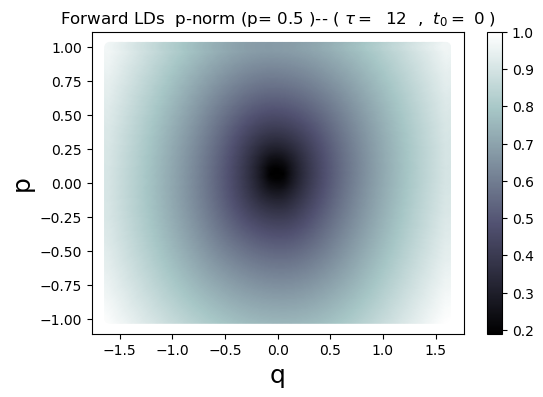

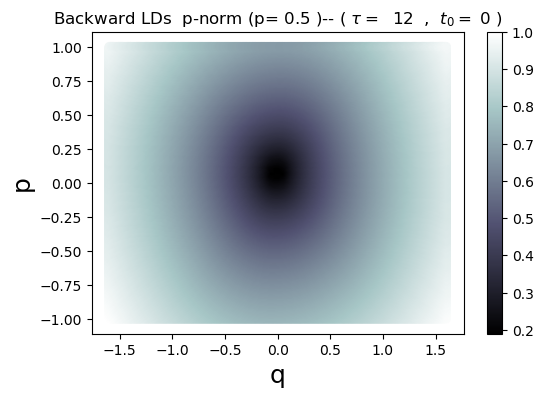

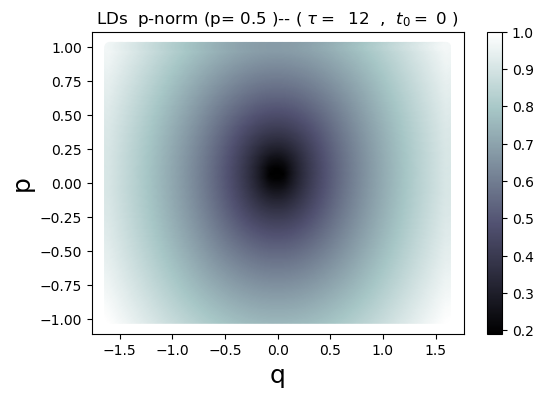

In [29]:
# vector Field for the Dynamical System 
ds = HamCenter_1D;
# ds = HamDuffing_1D;
# ds = HamSaddle_1D;

# Computation of LDs
ld_fw,ld_bw = LDs_1D(t0,tau,flag_m,p_val,dt,xi,xf,nx,yi,yf,ny,ds,flag_pert,pert_params);

# Draw Forward LDs
flag_type = 1;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw Bacward LDs
flag_type = 2;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw LDs
flag_type = 3;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

### Hamilton Saddle

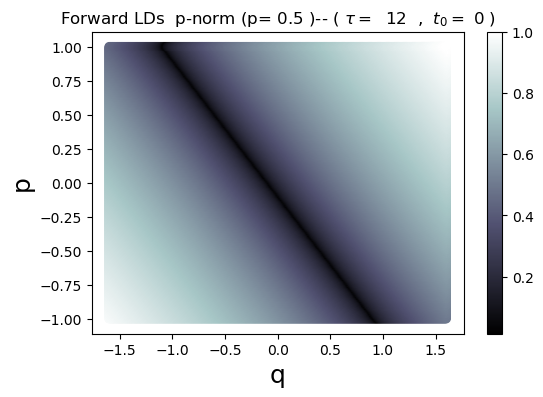

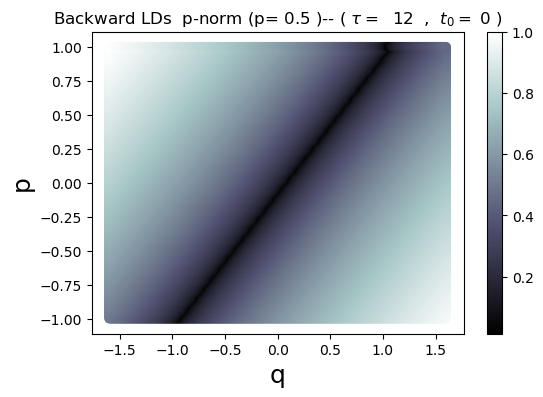

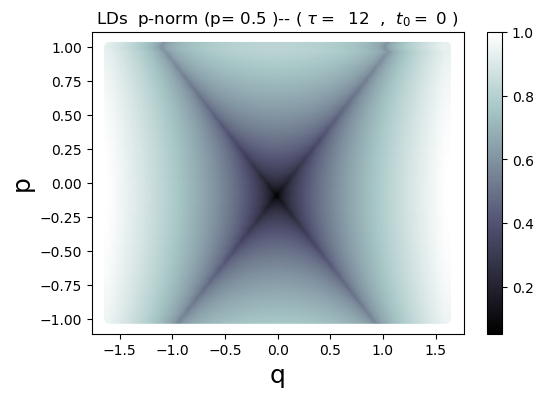

In [30]:
# vector Field for the Dynamical System 
# ds = HamCenter_1D;
# ds = HamDuffing_1D;
ds = HamSaddle_1D;

# Computation of LDs
ld_fw,ld_bw = LDs_1D(t0,tau,flag_m,p_val,dt,xi,xf,nx,yi,yf,ny,ds,flag_pert,pert_params);

# Draw Forward LDs
flag_type = 1;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw Bacward LDs
flag_type = 2;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw LDs
flag_type = 3;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

### Hamilton Duffing

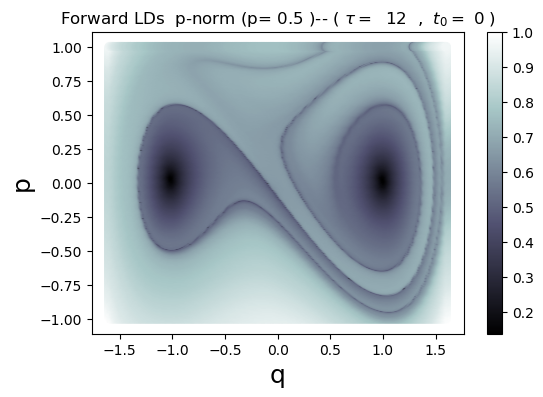

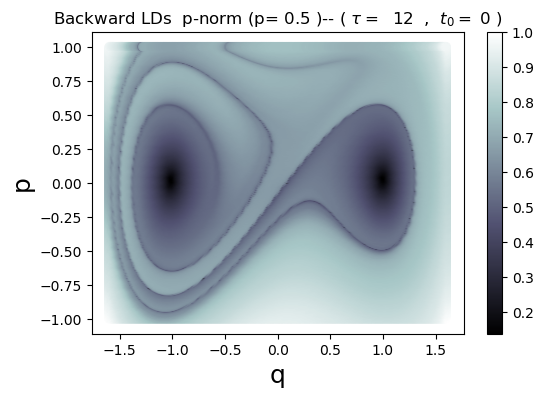

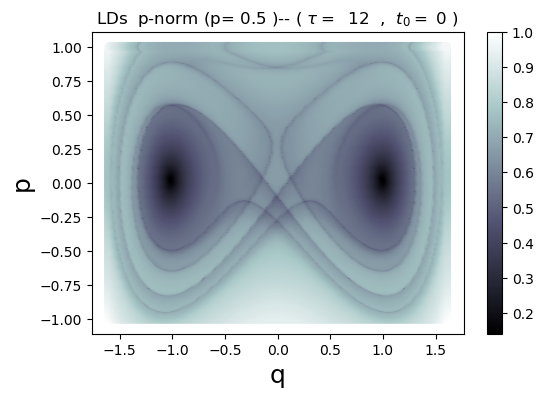

In [31]:
# vector Field for the Dynamical System 
# ds = HamCenter_1D;
ds = HamDuffing_1D;
# ds = HamSaddle_1D;

# Computation of LDs
ld_fw,ld_bw = LDs_1D(t0,tau,flag_m,p_val,dt,xi,xf,nx,yi,yf,ny,ds,flag_pert,pert_params);

# Draw Forward LDs
flag_type = 1;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw Bacward LDs
flag_type = 2;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw LDs
flag_type = 3;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# Version: Incorporation of Python-builtin integrator

## Functions

DOCUMENTATION

https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html

In [1]:
import numpy
import matplotlib.pyplot as plt

Redefined accumulator function

### Vector fields

CHANGES: input and outputs were redefined for every vector field function

In [2]:
def HamCenter_1D(t, points_flat):
    # Hamiltonian Model Parameter
    omega = 1;
    x, y = points_flat.reshape((nx*ny,2)).T
    v = numpy.array([ omega * y, - omega * x]).T
    return v.reshape(-1)

In [3]:
def HamSaddle_1D(t,points_flat):
    # Hamiltonian Model Parameter
    lamda = 1;
    x, y = points_flat.reshape((nx*ny,2)).T
    v = numpy.array([ lamda * y, lamda * x]).T
    return v.reshape(-1)

In [4]:
def forcing(t, points_flat, flag_pert, pert_params):
    x, y = points_flat.reshape((nx*ny,2)).T
    pert = numpy.zeros((len(x),1))
    # Perturbation parameters
    A = pert_params[0];  # Amplitude
    freq = pert_params[1];  # Frequency
    
    if flag_pert == 1:
        pert = A * numpy.sin(freq*t)
    elif flag_pert == 2:
        pert = A * numpy.sech(t) * numpy.sin(freq*t)
    else:
        pert = pert
    return pert

In [5]:
def HamDuffing_1D(t,points_flat):
    x, y = points_flat.reshape((nx*ny,2)).T
    perturbation = forcing(t, points_flat, flag_pert, pert_params)
    v = numpy.array([y, x - x**3 + perturbation]).T
    return v.reshape(-1)

Example with a single inital condition

In [6]:
def extract_y_final(solution_object):
    y_final = solution_object.y.T[-1]
    return y_final

### LD accumulator

In [7]:
def accum_LDs(LD_val, points_initial, points_next, flag_m, p, dt):
    if flag_m: # p-norm LDs
        accum = LD_val + ((abs(points_next[:,0] - points_initial[:,0]))**p + (abs(points_next[:,1] - points_initial[:,1]))**p) * dt ** (1 - p);
    else:  # arclength LDs
        accum = LD_val + sqrt((points_next[:,0] - points_next[:,0])**2 + (points_next[:,1] - points_initial[:,1])**2);
    return accum

### LD calculator

In [8]:
def lagrangian_descriptors(t0,tau,flag_m,p_value,dt,xi,xf,nx,yi,yf,ny,vector_field):
    # Create mesh for the computaion of Lagrangian Descriptors
    mesh = numpy.zeros((nx * ny,2)); 
    xp = numpy.linspace(xi,xf,nx);
    yp = numpy.linspace(yi,yf,ny);    
    [X,Y] = numpy.meshgrid(xp,yp);  
    mesh[:,0] = X.T.reshape(-1)
    mesh[:,1] = Y.T.reshape(-1)
    
    f = vector_field
    
    # Forward integration
    ld_forward = numpy.zeros(nx*ny)  # Array to store forward LDs
    points_initial = mesh

    for t in numpy.arange(t0, t0 + tau - dt, dt):
        ###################################
        # Inputs for integrator
        t_span = (t, t+dt)
        y0 = points_initial.reshape(-1)
        ###################################
        # Outputs from integration
        solution_object = integrator(f, t_span, y0)
        points_final = extract_y_final(solution_object).reshape((nx*ny, 2))
        ###################################
        # Compute LD
        ld_forward = accum_LDs(ld_forward, points_initial, points_final, True, p_value, dt)
        ###################################
        # For next iteration
        points_initial = points_final

    # Backward integration
    ld_backward = numpy.zeros(nx*ny);  # Array to store backward LDs
    points_initial = mesh
    
    for t in numpy.arange(t0, t0 - tau + dt, -dt):
        ###################################
        # Inputs for integrator
        t_span = (t, t-dt)
        y0 = points_initial.reshape(-1)
        ###################################
        # Outputs from integration
        solution_object = integrator(f, t_span, y0)
        points_final = extract_y_final(solution_object).reshape((nx*ny, 2))
        ###################################
        # Compute LD
        ld_backward = accum_LDs(ld_backward, points_initial, points_final, True, p_value, dt)
        ###################################
        # For next iteration
        points_initial = points_final
    
    return ld_backward, ld_forward

### LD plotter

In [9]:
def draw_LDs_1D(t0,tau,flag_m,p,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw):
    xp = numpy.linspace(xi,xf,nx);
    yp = numpy.linspace(yi,yf,ny);
    X,Y = numpy.meshgrid(xp,yp)

    if flag_m:
        str_meth = ['p-norm (p=',str(p),')--'];
    else:
        str_meth = ['arclength --'];
    
    if flag_type == 1:
        LD = ld_fw.reshape(nx,ny).T;
        string_title = ['Forward LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    elif flag_type == 2:
        LD = ld_bw.reshape(nx,ny).T;
        string_title = ['Backward LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    else:
        LD = (ld_fw + ld_bw).reshape(nx,ny).T;
        string_title = ['LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    
    LD = LD / LD.max();  # Scale LD output
    
    # Plot LDs
    fig,ax = plt.subplots(1,1,dpi=100)
    scatter = plt.scatter(X,Y,c=LD,cmap='bone')

    # Customise appearance
    ax.set_title(string_title, fontsize=12)
    ax.set_xlabel('q', fontsize=18)
    ax.set_ylabel('p', fontsize=18)
    ax.set_aspect('auto')

    fig.colorbar(scatter)

    plt.show()

## Benchmark examples

In [10]:
###################################
#
# Integration parameters
#
###################################
t0 = 0
tau = 12
dt = 0.1
###################################
#
# Lagrangian descriptor parameters
#
###################################
p_value = 1/2
flag_m = True
###################################
#
# Mesh parameters
#
###################################
xi,xf = [-1.6, 1.6]
yi,yf = [-1, 1]
nx, ny = [300, 300]
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1;
pert_params = [0.15, 0.5];
###################################
#
# Create mesh
#
###################################
mesh = numpy.zeros((nx * ny,2)) # Mesh to accumulate ?????
xp = numpy.linspace(xi,xf,nx)
yp = numpy.linspace(yi,yf,ny)    
[X,Y] = numpy.meshgrid(xp,yp)  # Grid in pahse-space
mesh[:,0] = X.T.reshape(-1)
mesh[:,1] = Y.T.reshape(-1)

In [11]:
import scipy.integrate
integrator = scipy.integrate.solve_ivp # RK45 (default)

### Hamilton Centre

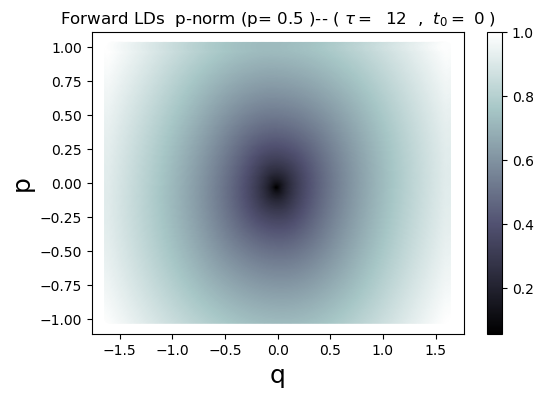

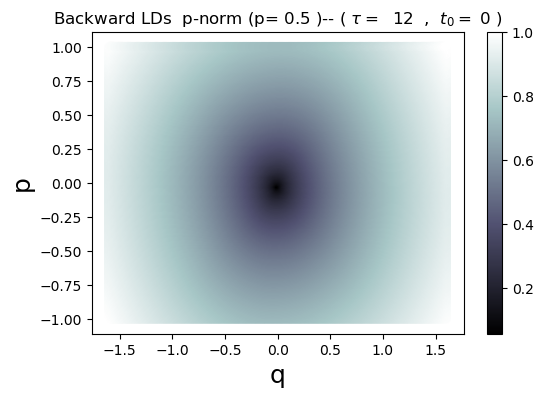

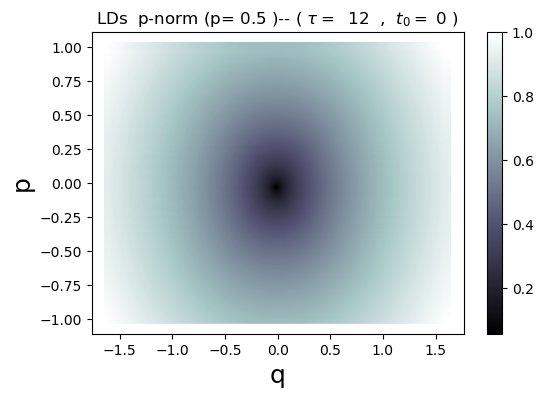

In [12]:
vector_field = HamCenter_1D
f = vector_field

# Computation of LDs
ld_backward, ld_forward = lagrangian_descriptors(t0,tau,flag_m,p_value,dt,xi,xf,nx,yi,yf,ny,vector_field)

for flag_type in [1,2,3]:
    draw_LDs_1D(t0,tau,flag_m,p_value,xi,xf,nx,yi,yf,ny,flag_type,ld_forward,ld_backward)

### Hamilton Saddle

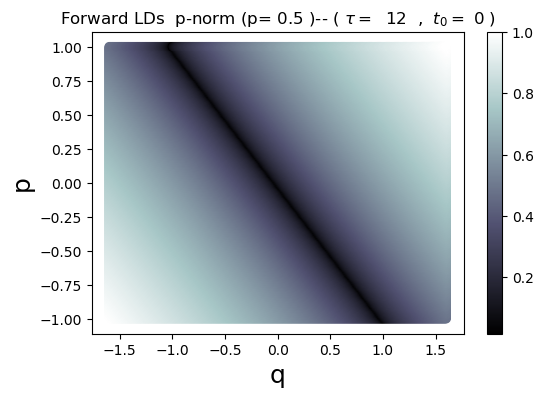

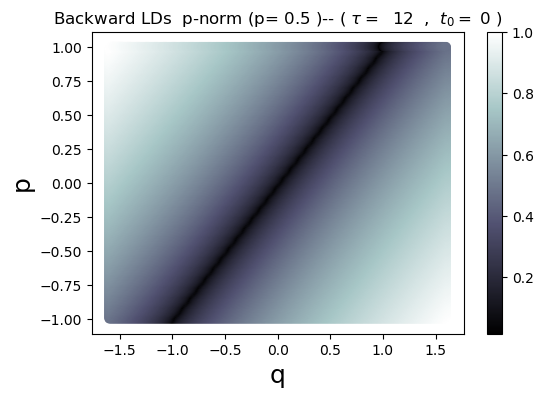

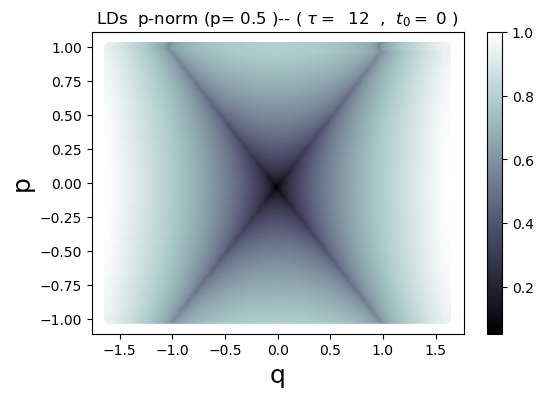

In [13]:
vector_field = HamSaddle_1D
f = vector_field

# Computation of LDs
ld_backward, ld_forward = lagrangian_descriptors(t0,tau,flag_m,p_value,dt,xi,xf,nx,yi,yf,ny,vector_field)

for flag_type in [1,2,3]:
    draw_LDs_1D(t0,tau,flag_m,p_value,xi,xf,nx,yi,yf,ny,flag_type,ld_forward,ld_backward)

### Hamilton Duffing (with forcing)

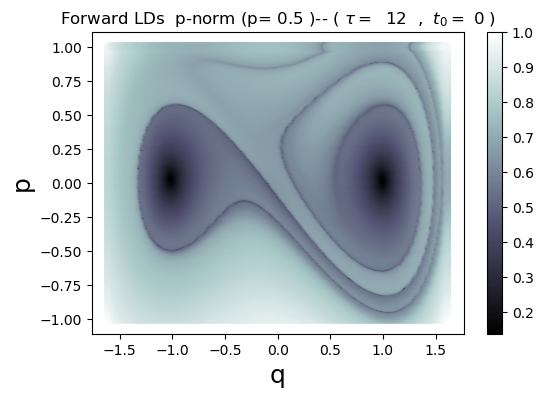

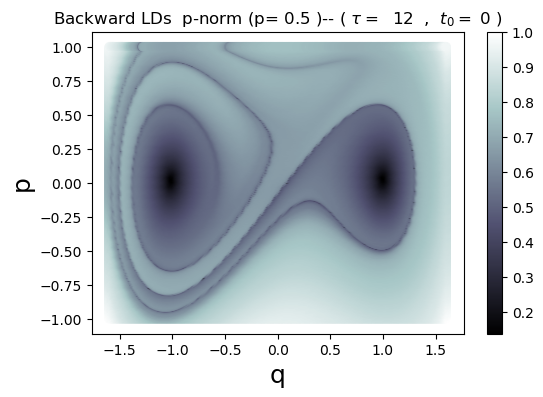

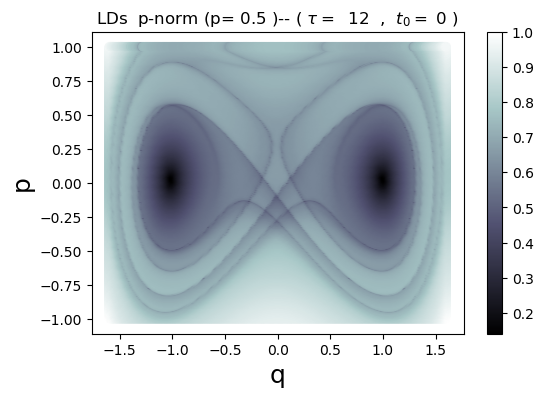

In [14]:
vector_field = HamDuffing_1D
f = vector_field

# Computation of LDs
ld_backward, ld_forward = lagrangian_descriptors(t0,tau,flag_m,p_value,dt,xi,xf,nx,yi,yf,ny,vector_field)

for flag_type in [1,2,3]:
    draw_LDs_1D(t0,tau,flag_m,p_value,xi,xf,nx,yi,yf,ny,flag_type,ld_forward,ld_backward)

# Version: Renaming variables and functions

## Functions

In [1]:
import numpy
import matplotlib.pyplot as plt

In [2]:
import scipy.integrate
integrator = scipy.integrate.solve_ivp # RK45 (default)

In [26]:
###################################
# Integration parameters
t0 = 0
tau = 12
dt = 0.1
###################################
# Lagrangian descriptor parameters
p_norm = 1/2
flag_m = True
###################################
# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

dim = 2
shape = (Nx*Ny, dim)
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1;
perturbation_params = [0.15, 0.5]

In [4]:
def generate_points():
    mesh = numpy.zeros(shape) # Mesh to accumulate 
    points_x = numpy.linspace(x_min, x_max, Nx)
    points_y = numpy.linspace(y_min, y_max, Ny)    
    X, Y = numpy.meshgrid(points_x, points_y)  # Grid in pahse-space
    mesh[:,0] = X.T.reshape(-1)
    mesh[:,1] = Y.T.reshape(-1)
    return mesh

In [5]:
def flatten_array(points): return points.reshape(-1)
def recover_array(points_flat, shape = shape): return points_flat.reshape(shape)

Define vector fields

__VERSION 1__

In [28]:
def HamCenter1D(t, points_flat):
    x, y = recover_array(points_flat).T
    # Hamiltonian Model Parameter
    omega = 1
    v = numpy.array([ omega * y, - omega * x]).T
    # Flatten output 
    v_flat = flatten_array(v)
    
    return v_flat

In [29]:
def HamSaddle1D(t, points_flat):
    x, y = recover_array(points_flat).T
    # Hamiltonian Model Parameter
    lamda = 1;
    v = numpy.array([ lamda * y, lamda * x]).T
    # Flatten output 
    v_flat = flatten_array(v)
    
    return v_flat

In [31]:
def forcing(t, points_flat, flag_pert, perturbation_params):
    x, y = recover_array(points_flat).T
    pert = numpy.zeros((len(x),1))
    # Perturbation parameters
    A, freq = perturbation_params # Amplitude and Frequency
    if flag_pert == 1:
        perturbation = A * numpy.sin(freq*t)
    elif flag_pert == 2:
        perturbation = A * numpy.sech(t) * numpy.sin(freq*t)
    else:
        perturbation = perturbation
    
    return perturbation

In [32]:
def HamDuffing1D(t, points_flat):
    x, y = recover_array(points_flat).T
    # Hamiltonian Model Parameter
    perturbation = forcing(t, points_flat, flag_pert, perturbation_params)
    v = numpy.array([y, x - x**3 + perturbation]).T
    # Flatten output 
    v_flat = flatten_array(v)
    
    return v_flat

Extracts solution from solver

In [7]:
def extract_y_final(solution_object):
    y_final = solution_object.y.T[-1]
    return y_final

In [8]:
def accumulate_lagrangian_descriptor(LD, points_initial, points_now, p_norm = p_norm, flag_m = True):
    if flag_m: # p-norm LDs
        LD_accum = LD + ((abs(points_now[:,0] - points_initial[:,0]))**p_norm + (abs(points_now[:,1] - points_initial[:,1]))**p_norm) * dt ** (1 - p_norm);
    else:  # arclength LDs
        LD_accum = LD + sqrt((points_now[:,0] - points_now[:,0])**2 + (points_now[:,1] - points_initial[:,1])**2);
    return LD_accum

Removed `dt` and `p` from functions since these are global variables.

<span style='color:red'>What about flag_m?</span>

In [9]:
def compute_lagrangian_descriptor(points_initial, vector_field, time_interval, dt = dt, norm = False):
    f = vector_field
    t_initial, t_final = time_interval
    if t_final < t_initial:
        dt = - dt
    else:
        dt = dt
    LD = numpy.zeros(Nx*Ny)  # Array to store forward LDs

    for t in numpy.arange(t_initial, t_final - dt, dt):
        ###################################
        # Inputs for integrator
        t_span = (t, t + dt)
        y0 = flatten_array(points_initial)
        ###################################
        # Outputs from integration
        solution_object = integrator(f, t_span, y0)
        points_final = extract_y_final(solution_object)
        points_final = recover_array(points_final)
        ###################################
        # Compute LD
        LD = accumulate_lagrangian_descriptor(LD, points_initial, points_final)
        ###################################
        # For next iteration
        points_initial = points_final
    return LD

Break down `lagrangian_descriptors` into separate code chunks

In [22]:
def draw_lagrangian_descriptor(LD, flag_m, flag_type):
    LD = LD.reshape(Nx, Ny).T # Reshape 1D array
    LD = LD / LD.max();  # Scale LD output
    ###################################
    # Plot LDs
    fig,ax = plt.subplots(1,1,dpi=100)
    
    points_x = numpy.linspace(x_min, x_max, Nx)
    points_y = numpy.linspace(y_min, y_max, Ny)    
    X, Y = numpy.meshgrid(points_x, points_y)

    scatter = plt.scatter(X,Y,c=LD,cmap='bone')
    ###################################
    # Customise appearance
    if flag_m:
        str_meth = ' '.join(['p-norm (p=',str(p_norm),')--'])
    else:
        str_meth = 'arclength --'
    
    if flag_type == 1:
        string_title = ['Forward LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    elif flag_type == 2:
        string_title = ['Backward LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    else:
        string_title = ['LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    
    string_title = ' '.join(string_title)
    
    ax.set_title(string_title, fontsize=12)
    ax.set_xlabel('q', fontsize=18)
    ax.set_ylabel('p', fontsize=18)
    ax.set_aspect('auto')

    fig.colorbar(scatter) # Add color bar

    plt.show()

## Benchmark examples

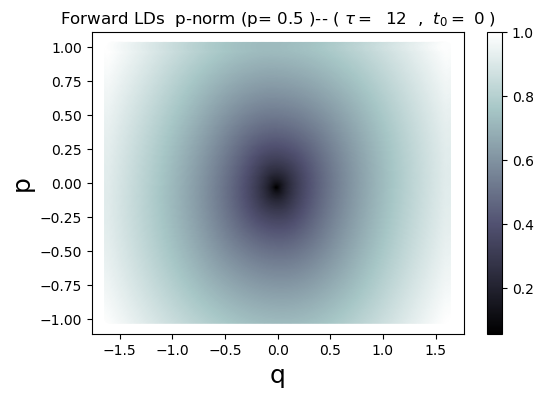

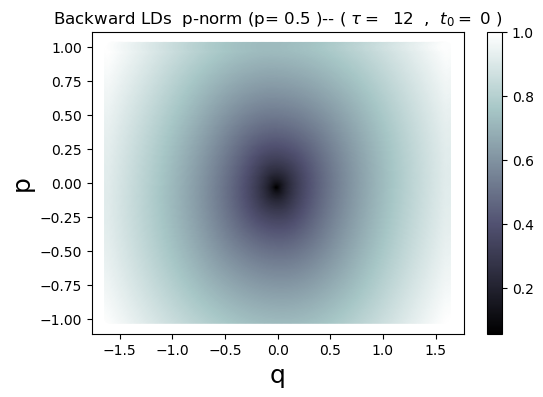

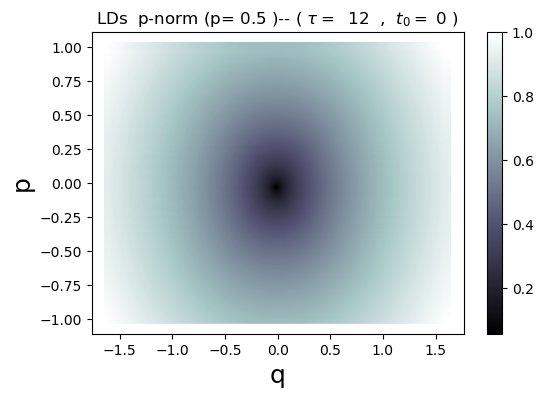

In [16]:
points_initial = generate_points()
vector_field = HamCenter1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(points_initial, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(points_initial, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

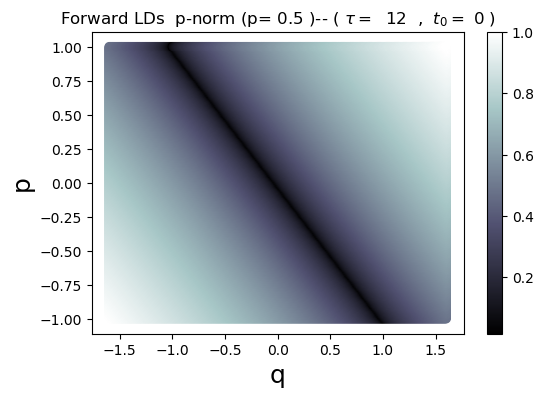

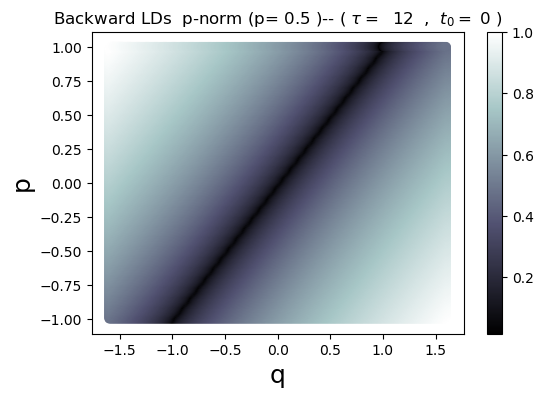

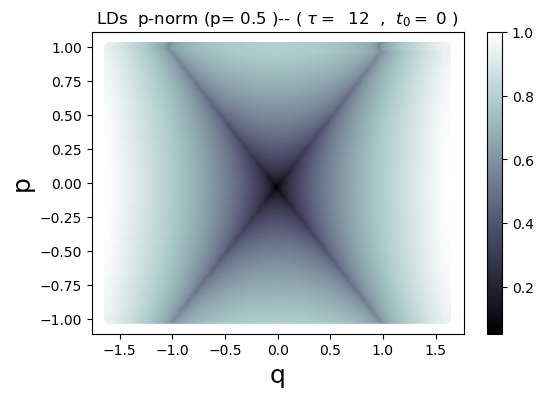

In [19]:
points_initial = generate_points()
vector_field = HamSaddle1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(points_initial, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(points_initial, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

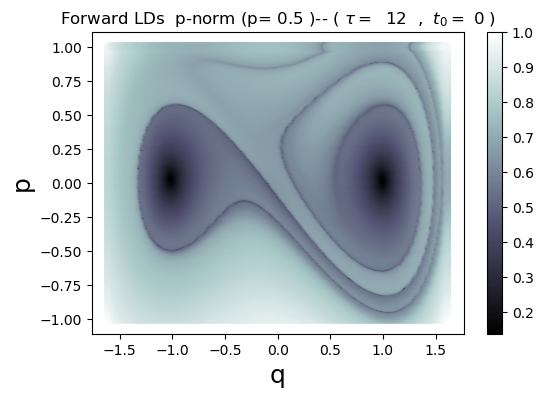

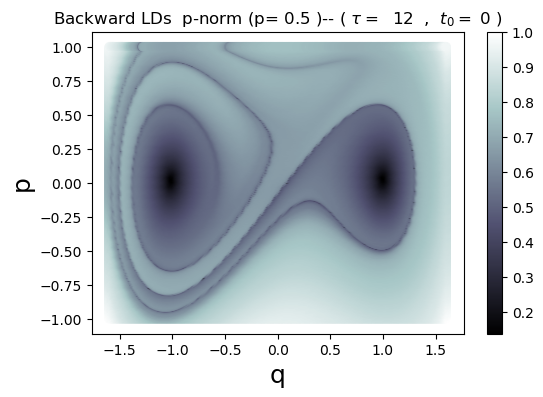

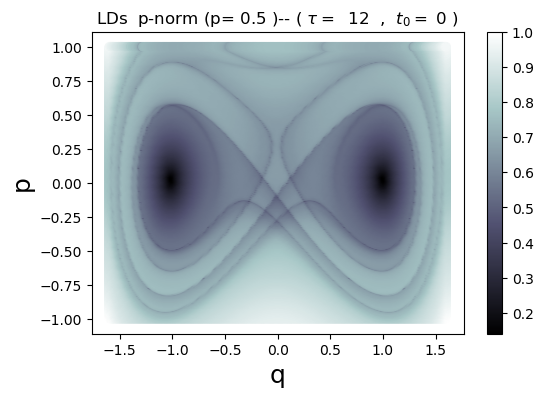

In [33]:
points_initial = generate_points()
vector_field = HamDuffing1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(points_initial, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(points_initial, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

# Version: Desentangled vector field functions

## Functions

In [1]:
import numpy
import matplotlib.pyplot as plt

In [2]:
import scipy.integrate
integrator = scipy.integrate.solve_ivp # RK45 (default)

INPUT PARAMETERS

In [3]:
###################################
# Integration parameters
t0 = 0
tau = 12
dt = 0.1
###################################
# Lagrangian descriptor parameters
p_norm = 1/2
flag_m = True
###################################
# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [300, 300]

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 2
shape = (Nx*Ny, dim)
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1;
perturbation_params = [0.15, 0.5]

In [4]:
def generate_points(GRID_PARAMETERS):
    x_min, x_max, Nx = GRID_PARAMETERS[0]
    y_min, y_max, Ny = GRID_PARAMETERS[1]
    mesh = numpy.zeros(shape) # Mesh to accumulate 
    points_x = numpy.linspace(x_min, x_max, Nx)
    points_y = numpy.linspace(y_min, y_max, Ny)    
    X, Y = numpy.meshgrid(points_x, points_y)  # Grid in pahse-space
    mesh[:,0] = X.T.reshape(-1)
    mesh[:,1] = Y.T.reshape(-1)
    return mesh

In [5]:
def flatten_array(points): return points.reshape(-1)
def recover_array(points_flat, shape = shape): return points_flat.reshape(shape)

### Vector fields

In [6]:
def HamCenter1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    omega = 1
    v = numpy.array([ omega * y, - omega * x]).T
    return v

In [7]:
def HamSaddle1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    lamda = 1
    v = numpy.array([ lamda * y, lamda * x]).T
    return v

In [8]:
def forcing(t, u, flag_pert, perturbation_params):
    x, y = u.T
    pert = numpy.zeros((len(x),1))
    # Perturbation parameters
    A, freq = perturbation_params # Amplitude and Frequency
    if flag_pert == 1:
        perturbation = A * numpy.sin(freq*t)
    elif flag_pert == 2:
        perturbation = A * numpy.sech(t) * numpy.sin(freq*t)
    else:
        perturbation = perturbation
    
    return perturbation

In [9]:
def HamDuffing1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    perturbation = forcing(t, u, flag_pert, perturbation_params)
    v = numpy.array([y, x - x**3 + perturbation]).T
    return v

Turn phase-space vector field to high-dimensional vector field

In [10]:
def vector_field_flat(t, points, vector_field):
    u = recover_array(points)
    v = vector_field(t, u)
    # Flatten output 
    v_flat = flatten_array(v)

    return v_flat

Extracts solution from solver

In [11]:
def extract_y_final(solution_object):
    y_final = solution_object.y.T[-1]
    return y_final

In [12]:
def accumulate_lagrangian_descriptor(LD, points_initial, points_now, p_norm = p_norm, flag_m = True):
    if flag_m: # p-norm LDs
        LD_accum = LD + ((abs(points_now[:,0] - points_initial[:,0]))**p_norm + (abs(points_now[:,1] - points_initial[:,1]))**p_norm) * dt ** (1 - p_norm);
    else:  # arclength LDs
        LD_accum = LD + sqrt((points_now[:,0] - points_now[:,0])**2 + (points_now[:,1] - points_initial[:,1])**2);
    return LD_accum

Removed `dt` and `p` from functions since these are global variables.

<span style='color:red'>What about flag_m?</span>

In [13]:
def compute_lagrangian_descriptor(points_initial, vector_field, time_interval, dt = dt, norm = False):
    f = vector_field_flat
    t_initial, t_final = time_interval
    if t_final < t_initial:
        dt = - dt
    else:
        dt = dt
    LD = numpy.zeros(Nx*Ny)  # Array to store forward LDs

    for t in numpy.arange(t_initial, t_final - dt, dt):
        ###################################
        # Inputs for integrator
        t_span = (t, t + dt)
        y0 = flatten_array(points_initial)
        ###################################
        # Outputs from integration
        solution_object = integrator(f, t_span, y0, args=(vector_field, ))
        points_final = extract_y_final(solution_object)
        points_final = recover_array(points_final)
        ###################################
        # Compute LD
        LD = accumulate_lagrangian_descriptor(LD, points_initial, points_final)
        ###################################
        # For next iteration
        points_initial = points_final
    return LD

Break down `lagrangian_descriptors` into separate code chunks

In [14]:
def draw_lagrangian_descriptor(LD, flag_m, flag_type):
    LD = LD.reshape(Nx, Ny).T # Reshape 1D array
#     LD = LD / LD.max()  # Scale LD output
    ###################################
    # Plot LDs
    fig,ax = plt.subplots(1,1,dpi=100)
    
    points_x = numpy.linspace(x_min, x_max, Nx)
    points_y = numpy.linspace(y_min, y_max, Ny)    
    X, Y = numpy.meshgrid(points_x, points_y)

    scatter = plt.scatter(X,Y,c=LD,cmap='bone')
    ###################################
    # Customise appearance
    if flag_m:
        str_meth = ' '.join(['p-norm (p=',str(p_norm),')--'])
    else:
        str_meth = 'arclength --'
    
    if flag_type == 1:
        string_title = ['Forward LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    elif flag_type == 2:
        string_title = ['Backward LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    else:
        string_title = ['LDs ', str_meth, '(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')']
    
    string_title = ' '.join(string_title)
    
    ax.set_title(string_title, fontsize=12)
    ax.set_xlabel('x', fontsize=18)
    ax.set_ylabel('y', fontsize=18)
    ax.set_aspect('auto')

    fig.colorbar(scatter) # Add color bar

    plt.show()

## Benchmark examples

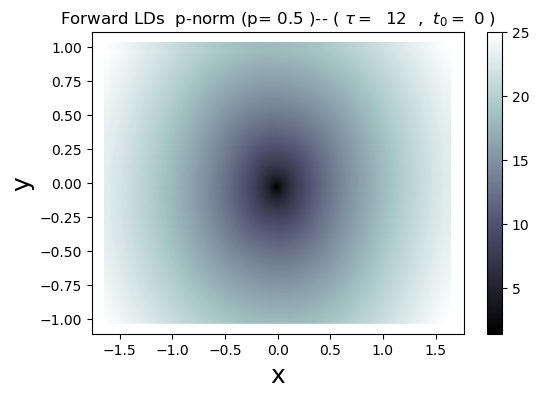

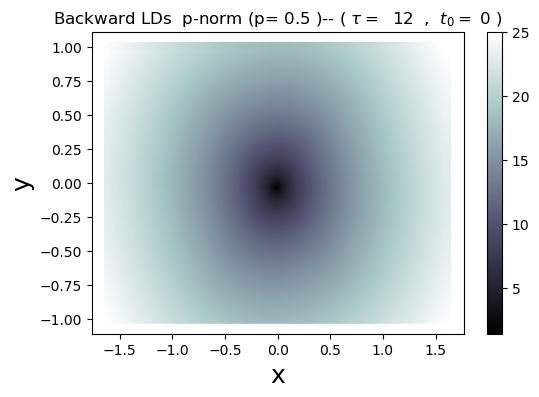

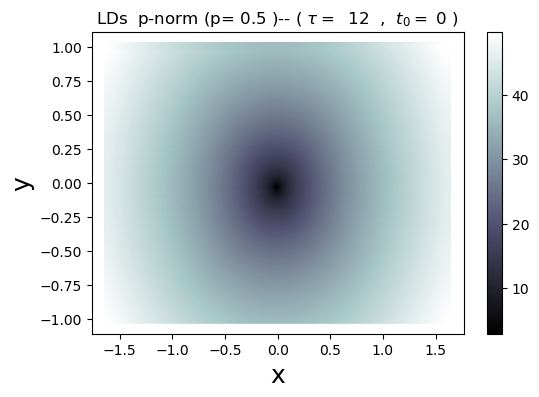

In [15]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamCenter1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

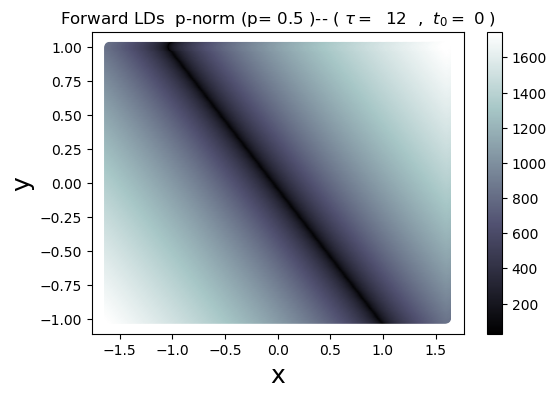

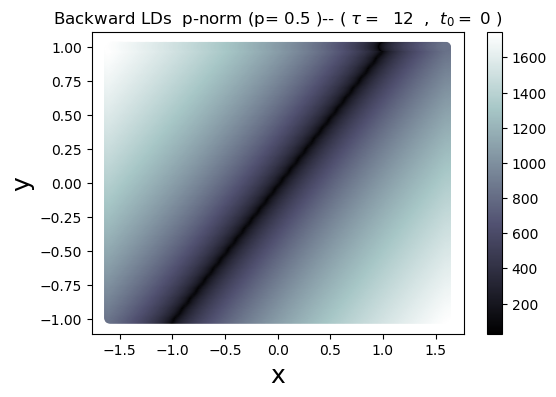

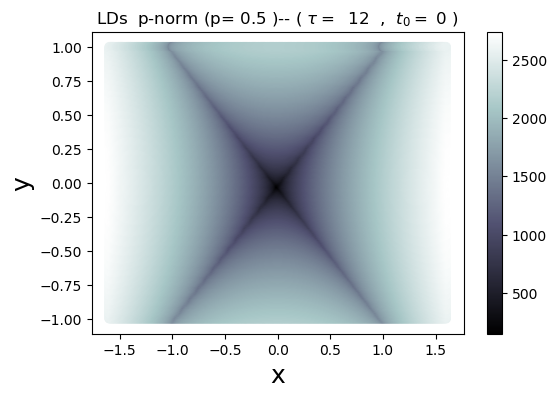

In [16]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamSaddle1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

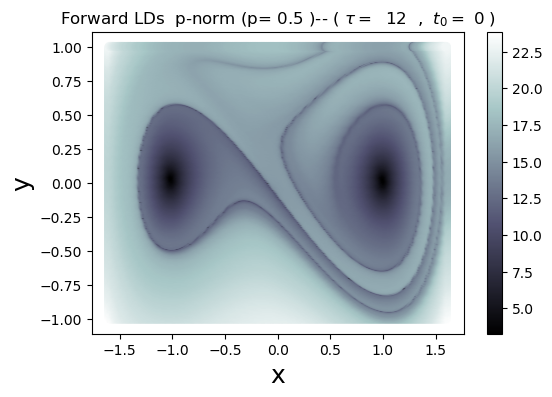

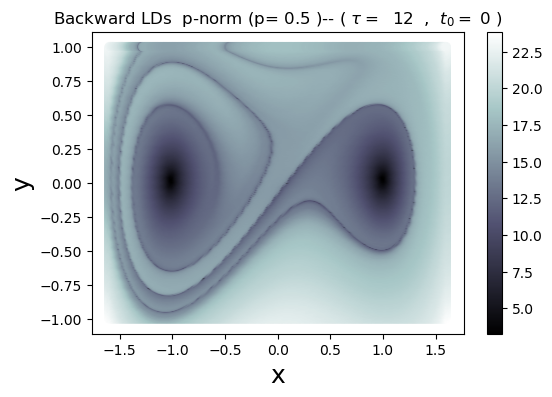

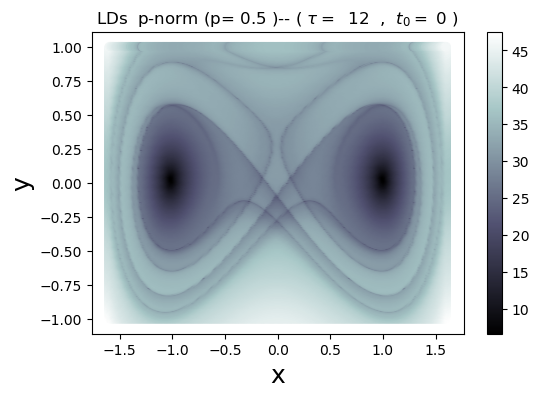

In [17]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamDuffing1D

time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

## Test: Hamilton Saddle-Node (blow up in finite time)

Define vector field $f(x,y) = (f_1, f_2)$

In [83]:
def HamSN1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    v = numpy.array([ y, -x -x**2]).T
    return v

with initial condition $(x_0, y_0) \in \mathbb{R}^2$ at time $t_0 \geq 0$

In [84]:
###################################
# Integration parameters
t0 = 0 # Initial time
tau = 1.5 # Time-interval length
dt = 0.1 # Timestep
###################################
# Lagrangian descriptor parameters
p_norm = 1/2 # p-value of Lp norm
flag_m = True
###################################
# Grid parameters
x_min,x_max = [-1.5, 1] # Grid limits X-axis
y_min,y_max = [-1, 1] # Grid limits Y-axis
Nx, Ny = [300, 300] # Number of points per axis

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 2 # Phase-space Dimension
shape = (Nx*Ny, dim) # Shape of array of grid-points
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1 
perturbation_params = [0.15, 0.5] # Amplitude & Frequency, periodic pertubation

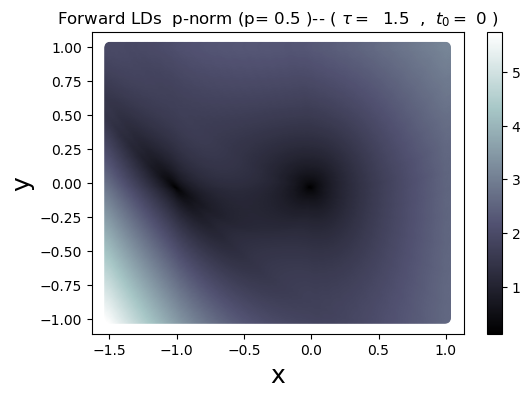

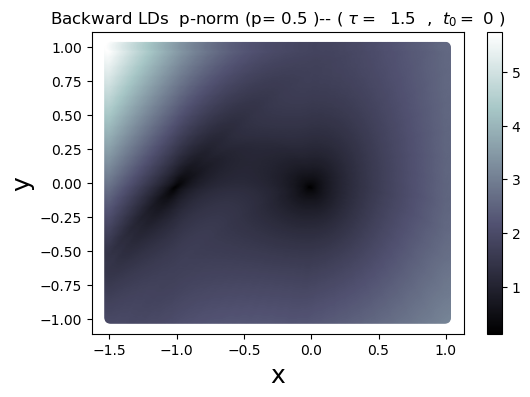

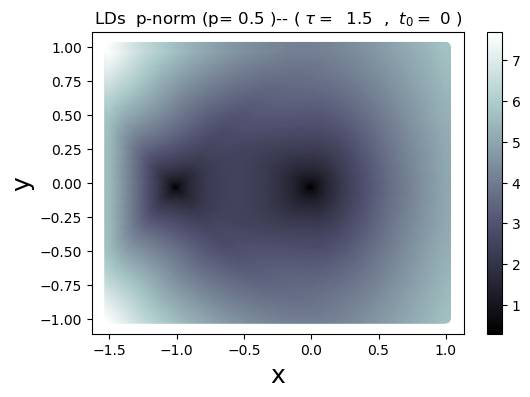

In [85]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamSN1D

# Compute and draw forward LD
time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

# Compute and draw backward LD
time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

# Compute and draw total LD
LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

<span style='color:red'><b>NOTE</b></span> The poor resolution of the invariant manifolds in the HSN system is due to numerical blow up, since the system escapes to inifinity in finite time, as its underlying bahviour. 

<span style='color:blue'><b>SOLUTION</b></span> Need to implement _Variable Time Integration_

# Version: Implementation with _Variable Time Integration_

## Tests

__MATLAB IMPLEMENTATION__ Victor's code. 

```bash
function vel = HamSaddle_1D(t,p,flag_pert,pert_params,flag_vt,boundx,boundy)
   
    vel = zeros(size(p,1),2);
    
    pert = forcing(t,p,flag_pert,pert_params);
       
    % Hamiltonian Model Parameter
    lambda = 1;
    
    x = p(:,1);
    y = p(:,2);
    
    if flag_vt
        % Escape Condition for Variable-Iterations
        idx = (x >= - boundx) & (x <= boundx) & (y >= -boundy) & (y <= boundy);
              
        vel(idx,1) = lambda .* y(idx);
        vel(idx,2) = lambda .* x(idx) + pert(idx);
    else
    	vel(:,1) = lambda .* y;
        vel(:,2) = lambda .* x + pert;       
    end
       
end


```

__PYTHON IMPLEMENTATION__

Define escape box boundaries

In [15]:
escape_box_x_min = -6
escape_box_x_max = 6
escape_box_y_min = -6
escape_box_y_max = 6

escape_box_BOUNDARIES = [
    [escape_box_x_min, escape_box_x_max],
    [escape_box_y_min, escape_box_y_max]
]

Vector field initially is equal to 0.
And x/y are given values from points.
But if x/y not within boundaries, then return vector field equal to zero, otheriwse continue as usually defined.

In [16]:
def HamSN1D(t, u):
    x, y = u.T
    # Define zero null vector field
    v = numpy.zeros(u.shape) 
    # Hamiltonian model parameter
    # Define escape condition
    u_indices = (x >= escape_box_x_min) & (x <= escape_box_x_max) & (y >= escape_box_y_min) & (y <= escape_box_y_max)
    
    v[u_indices == True] = numpy.array([ y[u_indices == True], -x[u_indices == True] -x[u_indices == True]**2]).T
    return v

In [17]:
###################################
# Integration parameters
t0 = 0 # Initial time
tau = 8 # Time-interval length
dt = 0.1 # Timestep
###################################
# Lagrangian descriptor parameters
p_norm = 1/2 # p-value of Lp norm
flag_m = True
###################################
# Grid parameters
x_min,x_max = [-1.5, 1] # Grid limits X-axis
y_min,y_max = [-1, 1] # Grid limits Y-axis
Nx, Ny = [300, 300] # Number of points per axis

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 2 # Phase-space Dimension
shape = (Nx*Ny, dim) # Shape of array of grid-points
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1 
perturbation_params = [0.15, 0.5] # Amplitude & Frequency, periodic pertubation

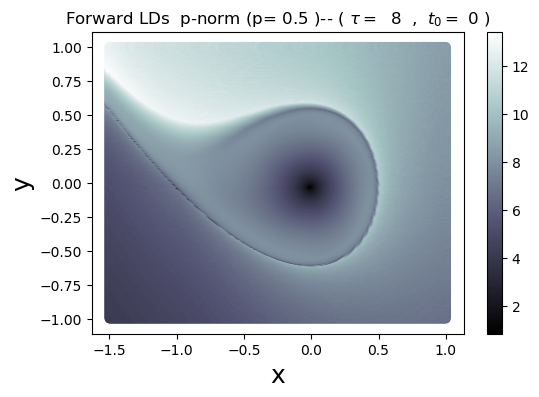

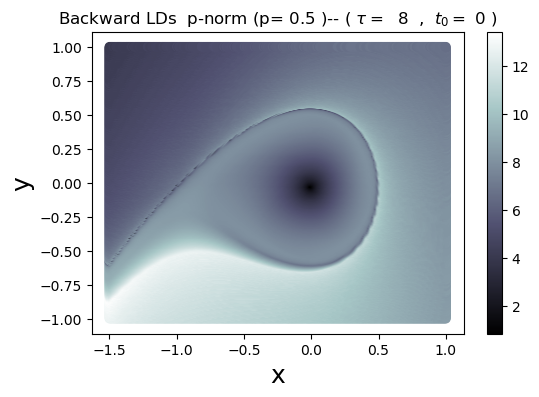

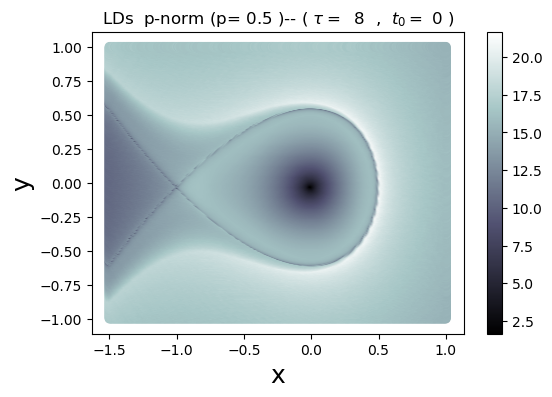

In [18]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamSN1D

# Compute and draw forward LD
time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_forward, True, 1)

# Compute and draw backward LD
time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval)
draw_lagrangian_descriptor(LD_backward, True, 2)

# Compute and draw total LD
LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

## Implementation

__NOTE__ The above implementation deals successfully with the issue of rapidly escaping trajectories. However, code implementation incorporates the _Escape Condition_ within the definition of the vector field function.

__CHANGES__ I will decouple the definition of the vector field from the escape condition, and insted I will couple this within the evaluated vector field for integration `vector_field_flat`. In this way it will avoid users from having to define the _Escape Condition_ every single time they define their `vector_field` functions. 

In [20]:
import numpy as np

In [21]:
escape_box_x_min = -6
escape_box_x_max = 6
escape_box_y_min = -6
escape_box_y_max = 6

escape_box_BOUNDARIES = [
    [escape_box_x_min, escape_box_x_max],
    [escape_box_y_min, escape_box_y_max]
]

In [22]:
def vector_field_flat(t, points, vector_field):
    u = points.reshape(shape)
    # Apply Escape condition
    x, y = u.T
    u_indices = (x >= escape_box_x_min) & (x <= escape_box_x_max) & (y >= escape_box_y_min) & (y <= escape_box_y_max)
    # Define output vector field
    v = numpy.zeros(u.shape)
    v[u_indices == True] = vector_field(t, u[u_indices == True])
    return v.flatten()

In [23]:
def lagrangian_descriptor(points_final, p_norm = 0.5, flag_m = True):
    points_difference = points_final[1:] - points_final[:-1]
    if flag_m: # p-norm LDs
        LD_rows = np.sum(np.abs(points_difference)**p_norm, axis=2)
        LD = np.sum(LD_rows, axis=0)
    else:  # arclength LDs
        LD_rows = np.sqrt(np.sum((points_final)**2),axis=2)
        LD = np.sum(LD_rows, axis=0)
    return LD

In [24]:
def compute_lagrangian_descriptor(points_initial, vector_field, time_interval, dt, norm = False):
    f = vector_field_flat # issue: defined as global function, independently of vector_field argument
    t_initial, t_final = time_interval
    if (t_final - t_initial)*dt < 0:
        dt = -dt
    y0 = points_initial.flatten() # All initial conditions taken at once
    t_evaluation = np.arange(t_initial, t_final + dt, dt) # Sequence of time-points for integration
    # Outputs from integration
    solution_object = integrator(f, time_interval, y0, t_eval=t_evaluation, args=(vector_field, )) #f and vector_field ambiguity needs fixing
    points_final = solution_object.y.T
    points_final = points_final.reshape((len(t_evaluation),shape[0], shape[1]))
    # Compute LD
    LD = lagrangian_descriptor(points_final)
    return LD

Input Parameters

In [25]:
###################################
# Integration parameters
t0 = 0 # Initial time
tau = 8 # Time-interval length
dt = 0.1 # Timestep
###################################
# Lagrangian descriptor parameters
p_norm = 1/2 # p-value of Lp norm
flag_m = True
###################################
# Grid parameters
x_min,x_max = [-1.5, 1] # Grid limits X-axis
y_min,y_max = [-1, 1] # Grid limits Y-axis
Nx, Ny = [300, 300] # Number of points per axis

GRID_PARAMETERS = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

dim = 2 # Phase-space Dimension
shape = (Nx*Ny, dim) # Shape of array of grid-points
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1 
perturbation_params = [0.15, 0.5] # Amplitude & Frequency, periodic pertubation

In [26]:
def HamSN1D(t, u):
    x, y = u.T
    # Hamiltonian Model Parameter
    v = numpy.array([ y, -x -x**2]).T
    return v

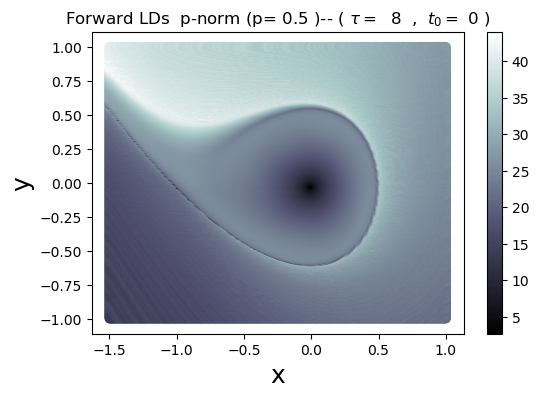

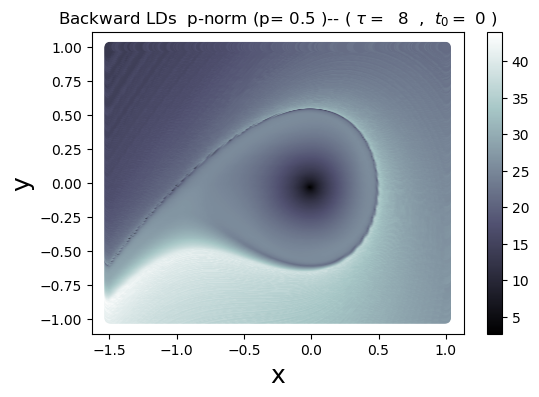

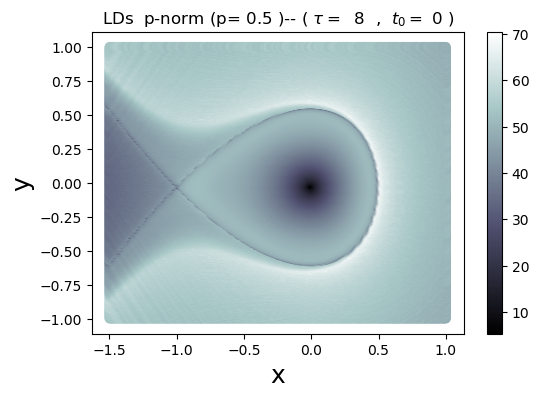

In [27]:
initial_conditions = generate_points(GRID_PARAMETERS)
vector_field = HamSN1D

# Compute and draw forward LD
time_interval = (t0, t0 + tau)
LD_forward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt)
draw_lagrangian_descriptor(LD_forward, True, 1)

# Compute and draw backward LD
time_interval = (t0, t0 - tau)
LD_backward = compute_lagrangian_descriptor(initial_conditions, vector_field, time_interval, dt)
draw_lagrangian_descriptor(LD_backward, True, 2)

# Compute and draw total LD
LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, True, 3)

# CHANGE LOG

* Redefined inputs/outputs as `(t, x)`, where `x` has to be a 1D-array of length `(2*Nx*Ny)` for every vector field function. This is needed to be able to use `scipy.integrate.solv_ivp`. Internally every vector field function, need to reshape the array to `(Nx*Ny, 2)` for matrix operations though.

* Temporarily, `forcing` was removed from `HamiltonCentre` and `HamiltonSaddle` vector field functions, but internally incorporated within `HamiltonDuffing`.

* Removed redundant call to perturbation parameters `pert_params` by LD calculator.

* Swapped variable and function names for more self-descriptive ones.

# TO-DOs

* Continue renaming variables and functions to be self-descriptive
* Remove redundant variable calls
* Reduce number of input arguments for all functions, use lists of variables or dictionaries to pass parameters to functions, for example. `PARAMETERS`
* Add description within functions
* Continue commenting functions

# NEXT STAGES
* Break down functions to achieve a more modular structure
* Maybe define classes of objects

# APPENDIX

## Create full list of requirements

```bash
!pip freeze > requeriments.txt
```

This will create a full list of 1) package names and 2) their exact versions installed in your environment.

You may want to shorten this list to avoid users installing unnecessary packages.

__NOTE__ It is important to keep in mind that portability across different _Operating Systems_ is not guaranteed. This means that exact package versions for some libraries may not be able to be installed in both Windows or Linux, for instance. This has several technical reasons.

## Install list of requirements with `conda`

First, make sure to use `pip` within the `conda` environment.

So, do as shown below.

```bash
# FIRST
conda install pip
# SECOND
pip install -r requeriments.txt
```

SOURCE: http://datumorphism.com/til/programming/python/python-anaconda-install-requirements/